In [162]:
# Imports
import re
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from covid_flu import config, utils

from IPython.display import display

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
sns.set_style('ticks')

# EDA of MIDAS data

The MIDAS Network is an organization that conducts and coordinates modelling for infectious disease and other public risks. They have collected a database of literature or study estimates of several parameters of interest with respect to COVID-19. The following parameters are available:

In [6]:
params_url = 'https://raw.githubusercontent.com/midas-network/COVID-19/master/information_for_contributors/parameter_list_v1.1_19Feb2020.csv'
params = pd.read_csv(params_url)
utils.display_all_rows(params.fillna(''))

,CDC high priority,category,name,abbreviation,units,definition,definition_source
0,no,tramsission,cumulative case count,,persons,,
1,no,tramsission,attack rate,AR,,,
2,no,tramsission,attack rate 0-4 year old,AR0_4,,,
3,no,tramsission,attack rate 5-17 year old,AR5_17,,,
4,no,tramsission,attack rate 18-49 year old,AR18_49,,,
5,no,tramsission,attack rate 50-64 year old,AR50_64,,,
6,no,tramsission,attack rate 65+ year old,AR65+,,,
7,no,tramsission,secondary attack rate households,,,,
8,no,tramsission,secondary attack rate in health care worker co...,,,,
9,no,tramsission,secondary attack rate in community contacts,,,,


Clearly there are a lot of interesting parameters. We can access the full CSV and look at how many estimates we have of each

In [135]:
midas_url = 'https://raw.githubusercontent.com/midas-network/COVID-19/master/parameter_estimates/2019_novel_coronavirus/estimates.csv'
df_params = pd.read_csv(midas_url)
print(df_params.shape)
utils.display_all_cols(df_params.head())

(421, 28)


,id,peer_review,peer_review_location,name,abbreviation,units,country,location_name,location_type,start_date,end_date,value_type,value,uncertainty_type,lower_bound,upper_bound,population,method_description,data_description,data_URL,date_publication,title_publication,type_publication,authors,publication_URL,entry_date,entry_person,entry_email
0,covid1,NaN,NaN,cumulative case count,NaN,persons,China,Wuhan City,city,2020-01-18,2020-01-18,"central estimate, unspecified",4000,confidence interval 95%,1000,9700,general population,NaN,7 imported cases internationally as of 9:00 G...,NaN,2020-01-22,Report 3: Transmissibility of 2019-nCoV,report,"Imai N., Dorigatti I., Cori A., Donnelly C., R...",https://www.imperial.ac.uk/mrc-global-infectio...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov
1,covid2,NaN,MedRxiv,cumulative case count,NaN,persons,China,Wuhan City,metropolitan area,2019-12-31,2020-01-29,median,31200,confidence interval 95%,23400,40400,general population,mobility model assuming travelers are exposed ...,"flight patterns, Wuhan city catchment population",NaN,2020-01-29,Early epidemiological analysis of the 2019-nCo...,report,Vespignani A.,https://www.mobs-lab.org/2019ncov.html,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov
2,covid3,NaN,NaN,date of emergence,NaN,NaN,China,Wuhan City,city,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,2020-11-19,2020-12-19,general population,NaN,24 publicly shared nCoV genomes,NaN,2020-01-23,Genomic analysis of nCoV spread. Situation rep...,executive summary,"Neher R., Hadfield J., Hodcroft E., Ilcisin M....",https://nextstrain.org/narratives/ncov/sit-rep...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov
3,covid4,positive,Eurosurveillance,basic reproduction number,R0,Nb,China,Wuhan City,city,2020-01-09,2020-01-11,Unspecified,0.3,confidence interval 95%,0.17,0.44,general population,"Using the method described by Cauchemez, assum...",first 41 confirmed cases,NaN,2020-01-12,Real-time tentative assessment of the epidemio...,report,"Wu P., Hao X., Lau EHY., Wong JY., Leung KSM.,...",https://eurosurveillance.org/content/10.2807/1...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov
4,covid5,NaN,BioRxiv,basic reproduction number,R0,Nb,China,Wuhan City,city,2019-11-27,2020-01-18,Unspecified,2.2,high density interval 90%,1.4,3.8,general population,performed stochastic simulations of early outb...,NaN,https://github.com/jriou/wcov,2020-01-23,PATTERN OF EARLY HUMAN-TO-HUMAN TRANSMISSION O...,preprint,"Riou J., Althaus C.",https://www.biorxiv.org/content/10.1101/2020.0...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov


In [136]:
df_params['name'].value_counts()

cumulative case count                               157
basic reproduction number                           135
incubation period                                    17
time from symptom onset to recovery                  16
effective reproduction number                        15
case fatality rate                                    8
doubling time                                         8
serial interval                                       6
proportion of symptomatics that die                   5
growth rate                                           4
transmission rate                                     4
ascertainment rate                                    4
time from symptom onset to death                      3
dispersion                                            3
latent period                                         3
infection fatality ratio                              3
time from symptom onset to isolation                  3
secondary attack rate                           

So the parameters that seem to have the most information are

* Cumulative case count (157)
* Basic reproduction number (R_0) (135)
* Incubation period (17)
* Time from symptom onset to recovery (15)
* Effective reproduction number (15)

Of these, cumulative case count is the least useful, since this is more accurately accessed through the full dataset of cases by country. The other 4 are far more interesting. R_0 determines on average the expected number of people that an infected person should infect with the disease. The incubation period determines the amount of time that an individual is infected before they show symptoms (and therefore before they self-isolate, get tested, etc.). Time from symptom onset to recovery determines how long an individual has symptoms and, taken together with incubation period, forms the average amount of time someone is sick with the virus. Finally, effective reproduction number is the amount of people that an infected individual is expected to infect given all the measures being taken, such as social distancing, treatment, handwashing, etc.

## Data cleaning

* Filling na's or missing data in each column
* Dropping strange rows
* Standardizing aliases

In [137]:
nan_fill_values = {
    'peer_review': 'negative',
    'peer_review_location': 'na'
}

df_params = df_params.fillna(nan_fill_values)

In [180]:
df_params.head(1)

,id,peer_review,peer_review_location,name,abbreviation,units,country,location_name,location_type,start_date,...,data_URL,date_publication,title_publication,type_publication,authors,publication_URL,entry_date,entry_person,entry_email,date
0,covid1,negative,na,cumulative case count,NaN,persons,China,Wuhan City,city,2020-01-18,...,NaN,2020-01-22,Report 3: Transmissibility of 2019-nCoV,report,"Imai N., Dorigatti I., Cori A., Donnelly C., R...",https://www.imperial.ac.uk/mrc-global-infectio...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-18


In [181]:
# Getting a single date for each estimate
def get_param_date(row):
    if row['date_publication'] != 'Unspecified':
        date = row['date_publication']
    if row['end_date'] != 'Unspecified':
        date = row['end_date']
    elif row['start_date'] != 'Unspecified':
        date = row['start_date']
    else:
        date = row['entry_date']
    try:
        return pd.to_datetime(date)
    except:
        return pd.to_datetime(date, format='%Y-%d-%m')

df_params['date'] = df_params.apply(get_param_date, axis=1)

In [182]:
# Parsing value column
def clean_value(value):
    if value == 'Unspecified':
        return np.nan
    elif value.endswith('%'):
        return float(value.strip('%')) / 100
    elif '-' in value:
        bounds = [float(b.strip()) for b in value.split('-')]
        return sum(bounds) / len(bounds)
    else:
        return float(value)
    
df_params['value'] = df_params['value'].apply(clean_value)

AttributeError: 'float' object has no attribute 'endswith'

In [183]:
# First, looking at the columns
utils.display_all_cols(df_params.head(20))

,id,peer_review,peer_review_location,name,abbreviation,units,country,location_name,location_type,start_date,end_date,value_type,value,uncertainty_type,lower_bound,upper_bound,population,method_description,data_description,data_URL,date_publication,title_publication,type_publication,authors,publication_URL,entry_date,entry_person,entry_email,date
0,covid1,negative,na,cumulative case count,NaN,persons,China,Wuhan City,city,2020-01-18,2020-01-18,"central estimate, unspecified",4000.0000,confidence interval 95%,1000,9700,general population,NaN,7 imported cases internationally as of 9:00 G...,NaN,2020-01-22,Report 3: Transmissibility of 2019-nCoV,report,"Imai N., Dorigatti I., Cori A., Donnelly C., R...",https://www.imperial.ac.uk/mrc-global-infectio...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-18
1,covid2,negative,MedRxiv,cumulative case count,NaN,persons,China,Wuhan City,metropolitan area,2019-12-31,2020-01-29,median,31200.0000,confidence interval 95%,23400,40400,general population,mobility model assuming travelers are exposed ...,"flight patterns, Wuhan city catchment population",NaN,2020-01-29,Early epidemiological analysis of the 2019-nCo...,report,Vespignani A.,https://www.mobs-lab.org/2019ncov.html,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-29
2,covid3,negative,na,date of emergence,NaN,NaN,China,Wuhan City,city,Unspecified,Unspecified,Unspecified,NaN,Unspecified,2020-11-19,2020-12-19,general population,NaN,24 publicly shared nCoV genomes,NaN,2020-01-23,Genomic analysis of nCoV spread. Situation rep...,executive summary,"Neher R., Hadfield J., Hodcroft E., Ilcisin M....",https://nextstrain.org/narratives/ncov/sit-rep...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-24
3,covid4,positive,Eurosurveillance,basic reproduction number,R0,Nb,China,Wuhan City,city,2020-01-09,2020-01-11,Unspecified,0.3000,confidence interval 95%,0.17,0.44,general population,"Using the method described by Cauchemez, assum...",first 41 confirmed cases,NaN,2020-01-12,Real-time tentative assessment of the epidemio...,report,"Wu P., Hao X., Lau EHY., Wong JY., Leung KSM.,...",https://eurosurveillance.org/content/10.2807/1...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-11
4,covid5,negative,BioRxiv,basic reproduction number,R0,Nb,China,Wuhan City,city,2019-11-27,2020-01-18,Unspecified,2.2000,high density interval 90%,1.4,3.8,general population,performed stochastic simulations of early outb...,NaN,https://github.com/jriou/wcov,2020-01-23,PATTERN OF EARLY HUMAN-TO-HUMAN TRANSMISSION O...,preprint,"Riou J., Althaus C.",https://www.biorxiv.org/content/10.1101/2020.0...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-18
5,covid6,negative,na,basic reproduction number,R0,Nb,China,Wuhan City,city,Unspecified,2020-01-18,mean,2.6000,best/worst case scenario,1.5,3.5,general population,measure proportion of simulations that are sta...,NaN,NaN,2020-01-24,Report 3: Transmissibility of 2019-nCoV,report,"Imai N., Cori A., Dorigatti I., Baguelin M., D...",https://www.imperial.ac.uk/media/imperial-coll...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-18
6,covid7,positive,International Journal of Infectious Diseases,basic reproduction number,R0,Nb,China,Mainland China,region,2020-01-10,2020-01-24,mean,2.2400,confidence interval 95%,1.96,2.55,general population,modeled the epidemic curve of 2019-nCoV cases ...,used case time series data,NaN,2020-01-27,Preliminary estimation of the basic reproducti...,preprint,"Zhao S., Ran J., Musa SS., Yang G., Lou Y., Ga...",https://www.biorxiv.org/content/10.1101/2020.0...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-24
7,covid8,negative,na,basic reproduction number,R0,Nb,China,Wuhan City,city,2019-11-01,2020-01-01,Unspecified,NaN,Unspecified,1.5,3.5,general population,NaN,total case count from Imperial College London,NaN,2020-01-23,Genomic analysis of nCoV spread. Situation rep...,executive summary,"Neher R., Hadfield J., Hodcroft E., Ilcisin M....",https://nextstrain.org/narrat

## Basic reproduction number (R_0)

In [184]:
df_r0 = df_params.query('name == "basic reproduction number"')

In [185]:
utils.display_all_cols(df_r0.head())

,id,peer_review,peer_review_location,name,abbreviation,units,country,location_name,location_type,start_date,end_date,value_type,value,uncertainty_type,lower_bound,upper_bound,population,method_description,data_description,data_URL,date_publication,title_publication,type_publication,authors,publication_URL,entry_date,entry_person,entry_email,date
3,covid4,positive,Eurosurveillance,basic reproduction number,R0,Nb,China,Wuhan City,city,2020-01-09,2020-01-11,Unspecified,0.30,confidence interval 95%,0.17,0.44,general population,"Using the method described by Cauchemez, assum...",first 41 confirmed cases,NaN,2020-01-12,Real-time tentative assessment of the epidemio...,report,"Wu P., Hao X., Lau EHY., Wong JY., Leung KSM.,...",https://eurosurveillance.org/content/10.2807/1...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-11
4,covid5,negative,BioRxiv,basic reproduction number,R0,Nb,China,Wuhan City,city,2019-11-27,2020-01-18,Unspecified,2.20,high density interval 90%,1.4,3.8,general population,performed stochastic simulations of early outb...,NaN,https://github.com/jriou/wcov,2020-01-23,PATTERN OF EARLY HUMAN-TO-HUMAN TRANSMISSION O...,preprint,"Riou J., Althaus C.",https://www.biorxiv.org/content/10.1101/2020.0...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-18
5,covid6,negative,na,basic reproduction number,R0,Nb,China,Wuhan City,city,Unspecified,2020-01-18,mean,2.60,best/worst case scenario,1.5,3.5,general population,measure proportion of simulations that are sta...,NaN,NaN,2020-01-24,Report 3: Transmissibility of 2019-nCoV,report,"Imai N., Cori A., Dorigatti I., Baguelin M., D...",https://www.imperial.ac.uk/media/imperial-coll...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-18
6,covid7,positive,International Journal of Infectious Diseases,basic reproduction number,R0,Nb,China,Mainland China,region,2020-01-10,2020-01-24,mean,2.24,confidence interval 95%,1.96,2.55,general population,modeled the epidemic curve of 2019-nCoV cases ...,used case time series data,NaN,2020-01-27,Preliminary estimation of the basic reproducti...,preprint,"Zhao S., Ran J., Musa SS., Yang G., Lou Y., Ga...",https://www.biorxiv.org/content/10.1101/2020.0...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-24
7,covid8,negative,na,basic reproduction number,R0,Nb,China,Wuhan City,city,2019-11-01,2020-01-01,Unspecified,NaN,Unspecified,1.5,3.5,general population,NaN,total case count from Imperial College London,NaN,2020-01-23,Genomic analysis of nCoV spread. Situation rep...,executive summary,"Neher R., Hadfield J., Hodcroft E., Ilcisin M....",https://nextstrain.org/narratives/ncov/sit-rep...,2020-01-24,Cecile Viboud,viboudc@mail.nih.gov,2020-01-01


Here are all the estimates plotted according to when they were taken:

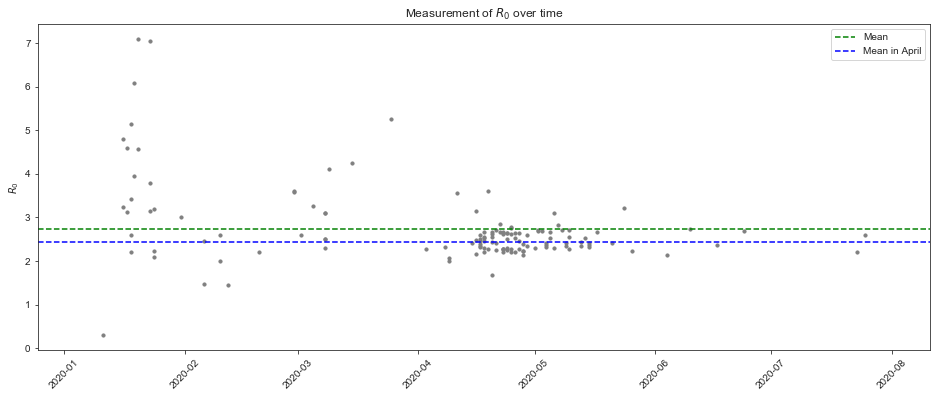

In [187]:
r0_mean = df_r0['value'].mean()
r0_mean_april = df_r0.loc[df_r0['date'] > pd.to_datetime('2020-04-01'), 'value'].median()

plt.figure(figsize=(16, 6))
plt.scatter(df_r0['date'], df_r0['value'], s=10, c='gray')
plt.xticks(rotation=45)
plt.ylabel("$R_0$")
plt.axhline(r0_mean, c='green', linestyle='--', label='Mean')
plt.axhline(r0_mean_april, c='blue', linestyle='--', label='Mean in April')
plt.legend()
plt.title("Measurement of $R_0$ over time");

In [188]:
df_r0['country'].value_counts()

China           27
Italy            8
Iran             3
Japan            2
Brazil           2
                ..
Viet Nam         1
Philippines      1
Burkina Faso     1
Switzerland      1
Estonia          1
Name: country, Length: 98, dtype: int64

Clearly the vast majority of the information about $R_0$ is from China. We can check which ones aren't from China:

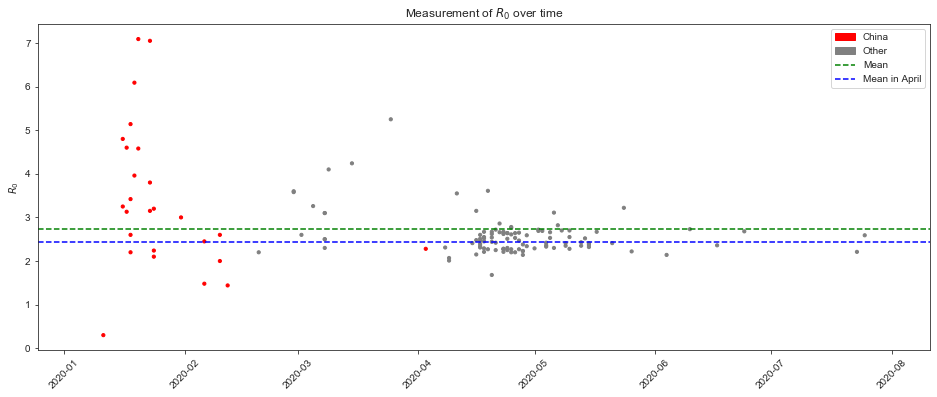

In [189]:
r0_mean = df_r0['value'].mean()
r0_mean_april = df_r0.loc[df_r0['date'] > pd.to_datetime('2020-04-01'), 'value'].median()

from_china = df_r0['country'].apply(lambda x: int(x == 'China'))
cmap = ['gray', 'red']
colors = [cmap[x] for x in from_china]

china_patch = mpl.patches.Patch(color=cmap[1], label='China')
other_patch = mpl.patches.Patch(color=cmap[0], label='Other')

plt.figure(figsize=(16, 6))
plt.scatter(df_r0['date'], df_r0['value'], s=10, c=colors)
plt.xticks(rotation=45)
plt.ylabel("$R_0$")
mean_line = plt.axhline(r0_mean, c='green', linestyle='--', label='Mean')
mean_april_line = plt.axhline(r0_mean_april, c='blue', linestyle='--', label='Mean in April')
plt.legend([china_patch, other_patch, mean_line, mean_april_line], ['China', 'Other', 'Mean', 'Mean in April'])
plt.title("Measurement of $R_0$ over time");

Interestingly the vast majority of measurements from before March were from China and include many higher values (in the range of 3-7). Meanwhile, the measurements in March onwards tend to be from other countries and are in a much tighter range (roughly 1.8-3)

## Incubation period

There aren't many observations here so we can quickly examine them all:

In [191]:
df_inc = df_params.query('name == "incubation period"')

In [192]:
utils.display_all(df_inc)

,id,peer_review,peer_review_location,name,abbreviation,units,country,location_name,location_type,start_date,end_date,value_type,value,uncertainty_type,lower_bound,upper_bound,population,method_description,data_description,data_URL,date_publication,title_publication,type_publication,authors,publication_URL,entry_date,entry_person,entry_email,date
22,covid23,negative,OutbreakScience,incubation period,NaN,days,China,excluding Wuhan,country,2019-12-31,2020-01-25,median,4.60,confidence interval 95%,3.3,5.7,general population,used dates of three critical points of course ...,confirmed cases reported from governmental web...,NaN,2020-01-28,Epidemiological characteristics of novel coron...,preorint,"Linton NM., Kobayashi T., Yang Y., Hayashi K.,...",https://www.medrxiv.org/content/medrxiv/early/...,2020-02-14,Jessica Salerno,jek118@pitt.edu,2020-01-25
23,covid24,negative,OutbreakScience,incubation period,NaN,days,China,including Wuhan,country,2019-12-31,2020-01-25,median,5.00,confidence interval 95%,4.1,5.8,general population,used dates of three critical points of course ...,confirmed cases reported from governmental web...,NaN,2020-01-28,Epidemiological characteristics of novel coron...,preorint,"Linton NM., Kobayashi T., Yang Y., Hayashi K.,...",https://www.medrxiv.org/content/medrxiv/early/...,2020-02-14,Jessica Salerno,jek118@pitt.edu,2020-01-25
27,covid28,negative,na,incubation period,NaN,days,China,Mainland China,region,2019-12-10,2020-01-25,median,5.40,confidence interval 95%,4.2,6.7,general population,"fitted Weibell, exponential, and lognormal dis...",travel history and symptom onset of 149 confir...,https://github.com/InstituteforDiseaseModeling...,2020-01-26,nCoV: incubation period distribution,report,"Famulare, M.",https://institutefordiseasemodeling.github.io/...,2020-02-14,Mike Famulare,mfamulare@idmod.org,2020-01-25
30,covid31,positive,Annals of Internal Medicine,incubation period,NaN,days,China,excluding Wuhan,region,2019-12-01,2019-02-04,median,5.20,confidence interval 95%,4.4,6,general population,estimated incubation time using parametric acc...,"based on confirmed, publicly reported cases ou...",NaN,2020-02-04,The incubation period of 2019-nCoV from public...,journal article,"Lauer SA., Grantz KH., Bi Q., Jones FK., Zheng...",https://annals.org/aim/fullarticle/2762808/inc...,2020-02-15,Jessica Salerno,jek118@pitt.edu,2019-02-04
31,covid32,negative,medRxiv,incubation period,NaN,days,China,Unspecified,province,2019-12-31,2020-02-10,Unspecified,4.20,confidence interval 95%,3.5,5.1,general population,NaN,140 case reports from provinces in China and d...,NaN,2020-02-11,"The novel coronavirus, 2019-nCoV, is highly co...",preprint,"Sanche S., Lin Y., Xu C., Romero-Severson E., ...",https://www.medrxiv.org/content/10.1101/2020.0...,2020-02-19,Jessica Salerno,jek118@pitt.edu,2020-02-10
114,covid115,negative,medRxiv,incubation period,NaN,days,Singapore,Unspecified,country,2020-01-19,2020-02-26,mean,6.60,Unspecified,1.8,11.4,general population,NaN,Singapore data from Ministry of Health Singapo...,github.com/carolinecolijn/ClustersCOVID19,2020-03-06,Transmission interval estimates suggest pre-sy...,preprint,"Tindale LC., Coombe M., Stockdale JE., Garlock...",https://www.medrxiv.org/content/10.1101/2020.0...,2020-03-10,Jessica Salerno,jek118@pitt.edu,2020-02-26
117,covid118,negative,medRxiv,incubation period,NaN,days,China,Tianjin,city,2020-01-21,2020-02-22,mean,5.40,Unspecified,0.9,9.9,general population,NaN,Tianjin data had 135 confirmed cases from Jan ...,github.com/carolinecolijn/ClustersCOVID19,2020-03-06,Transmission interval estimates suggest pre-sy...,preprint,"Tindale LC., Coombe M., Stockdale JE., Garlock...",https://www.medrxiv.org/content/10.1101/2020.0...,2020-03-10,Jessica Salerno,jek118@pitt.edu,2020-02-22
118,covid119,negative,medRxiv,incubation period,NaN,days,China,Tianjin,city,2020-01-21,2020-02-22,mean,5.20,Unspecified,1,9.4,general population,NaN,Tianjin data had 135 confirmed cases from Jan ...,github.com/c

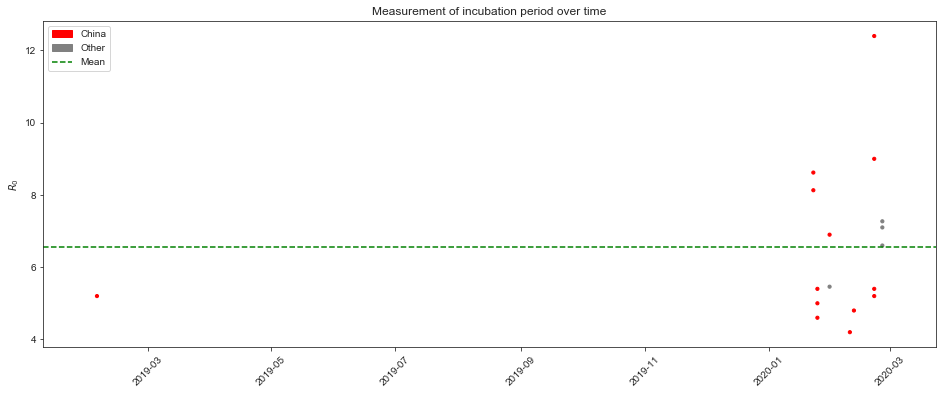

In [193]:
inc_mean = df_inc['value'].mean()

from_china = df_inc['country'].apply(lambda x: int(x == 'China'))
cmap = ['gray', 'red']
colors = [cmap[x] for x in from_china]

china_patch = mpl.patches.Patch(color=cmap[1], label='China')
other_patch = mpl.patches.Patch(color=cmap[0], label='Other')

plt.figure(figsize=(16, 6))
plt.scatter(df_inc['date'], df_inc['value'], s=10, c=colors)
plt.xticks(rotation=45)
plt.ylabel("$R_0$")
mean_line = plt.axhline(inc_mean, c='green', linestyle='--', label='Mean')
plt.legend([china_patch, other_patch, mean_line], ['China', 'Other', 'Mean'])
plt.title("Measurement of incubation period over time");

In [194]:
df_inc[['value']].describe()

,value
count,17.000000
mean,6.545882
std,2.094935
min,4.200000
25%,5.200000
50%,5.460000
75%,7.270000
max,12.400000


Once again, the better part of the observations for this parameter are from China, although most are from mid-to-late February.

## Time from symptom onset to recovery

In [195]:
param_name = 'time from symptom onset to recovery'

df_subset = df_params.query('name == @param_name')
utils.display_all(df_subset)

,id,peer_review,peer_review_location,name,abbreviation,units,country,location_name,location_type,start_date,end_date,value_type,value,uncertainty_type,lower_bound,upper_bound,population,method_description,data_description,data_URL,date_publication,title_publication,type_publication,authors,publication_URL,entry_date,entry_person,entry_email,date
144,covid145,negative,medRxiv,time from symptom onset to recovery,NaN,days,China,Shenzhen,city,2020-01-14,2020-02-12,median,20.3,95% confidence interval,19.4,21.3,all age group,time from symptom onset to recovery estimated ...,based on 228 cases with known outcomes,NaN,2020-03-04,Epidemiology and Transmission of COVID-19 in S...,preprint,"Qifang Bi,Yongsheng Wu, Shujiang Mei, Chenfei ...",https://www.medrxiv.org/content/10.1101/2020.0...,2020-03-06,Jessica Salerno,jek118@pitt.edu,2020-02-12
145,covid146,negative,medRxiv,time from symptom onset to recovery,NaN,days,China,Shenzhen,city,2020-01-14,2020-02-12,median,21.2,95% confidence interval,20.2,22.3,age group 0-9,time from symptom onset to recovery estimated ...,based on 228 cases with known outcomes,NaN,2020-03-04,Epidemiology and Transmission of COVID-19 in S...,preprint,"Qifang Bi,Yongsheng Wu, Shujiang Mei, Chenfei ...",https://www.medrxiv.org/content/10.1101/2020.0...,2020-03-06,Jessica Salerno,jek118@pitt.edu,2020-02-12
146,covid147,negative,medRxiv,time from symptom onset to recovery,NaN,days,China,Shenzhen,city,2020-01-14,2020-02-12,median,17.5,95% confidence interval,15.3,20,age group 10-19,time from symptom onset to recovery estimated ...,based on 228 cases with known outcomes,NaN,2020-03-04,Epidemiology and Transmission of COVID-19 in S...,preprint,"Qifang Bi,Yongsheng Wu, Shujiang Mei, Chenfei ...",https://www.medrxiv.org/content/10.1101/2020.0...,2020-03-06,Jessica Salerno,jek118@pitt.edu,2020-02-12
147,covid148,negative,medRxiv,time from symptom onset to recovery,NaN,days,China,Shenzhen,city,2020-01-14,2020-02-12,median,19.1,95% confidence interval,15.8,22.9,age group 20-20,time from symptom onset to recovery estimated ...,based on 228 cases with known outcomes,NaN,2020-03-04,Epidemiology and Transmission of COVID-19 in S...,preprint,"Qifang Bi,Yongsheng Wu, Shujiang Mei, Chenfei ...",https://www.medrxiv.org/content/10.1101/2020.0...,2020-03-06,Jessica Salerno,jek118@pitt.edu,2020-02-12
148,covid149,negative,medRxiv,time from symptom onset to recovery,NaN,days,China,Shenzhen,city,2020-01-14,2020-02-12,median,19.2,95% confidence interval,17.5,21,age group 30-39,time from symptom onset to recovery estimated ...,based on 228 cases with known outcomes,NaN,2020-03-04,Epidemiology and Transmission of COVID-19 in S...,preprint,"Qifang Bi,Yongsheng Wu, Shujiang Mei, Chenfei ...",https://www.medrxiv.org/content/10.1101/2020.0...,2020-03-06,Jessica Salerno,jek118@pitt.edu,2020-02-12
149,covid150,negative,medRxiv,time from symptom onset to recovery,NaN,days,China,Shenzhen,city,2020-01-14,2020-02-12,median,19.2,95% confidence interval,18,20.5,age group 40-49,time from symptom onset to recovery estimated ...,based on 228 cases with known outcomes,NaN,2020-03-04,Epidemiology and Transmission of COVID-19 in S...,preprint,"Qifang Bi,Yongsheng Wu, Shujiang Mei, Chenfei ...",https://www.medrxiv.org/content/10.1101/2020.0...,2020-03-06,Jessica Salerno,jek118@pitt.edu,2020-02-12
150,covid151,negative,medRxiv,time from symptom onset to recovery,NaN,days,China,Shenzhen,city,2020-01-14,2020-02-12,median,21.6,95% confidence interval,20,23.4,age group 50-59,time from symptom onset to recovery estimated ...,based on 228 cases with known outcomes,NaN,2020-03-04,Epidemiology and Transmission of COVID-19 in S...,preprint,"Qifang Bi,Yongsheng Wu, Shujiang Mei, Chenfei ...",https://www.medrxiv.org/content/10.1101/2020.0...,2020-03-06,Jessica Salerno,jek118@pitt.edu,2020-02-12
151,covid152,negative,medRxiv,time from symptom onset to recovery,NaN,days,China,Shenzhen,city,2020-01-14,2020-02-12,median,22.4,95% confidence interval,20.8,24.1,age group 60-69

This parameter is only reported by one study but for different sub-populations and various surveillance methods. The overall mean is 20.3 days. If you combine the estimate for incubation period, the reported mean number of days of infection is roughly 26.8 days. At first glance, this seems slightly high. One thing to keep in mind is that this is symptomatic cases, likely the cases that had such a difficult case that it was detected and included in these studies.